In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

from ffflows.models import BaseFlow
from ffflows.utils import set_trainable
from ffflows.utils import get_activation, spline_inn, get_flow4flow, get_conditional_data, coupling_flow

from nflows.distributions import StandardNormal

from ffflows.data.conditional_plane import ScienceDataset

import yaml



device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)


cuda:2


# ncond = 0

In [2]:
eval_results_dir = "/global/ml4hep/spss/rrmastandrea/flows4flows/writeup2/"
eval_results_dir = "/global/home/users/rrmastandrea/flows4flows/writeup2/"

s = 0.5

def collect_all_data_nocond(key):
    
    transported_results = {}
    
    eval_dict_root = f"{eval_results_dir}/{key}_f4f/"
    results_root = pd.read_hdf(f"{eval_dict_root}/eval_data.h5")
    
    transported_results["left"] = [results_root["left_data_x"], results_root["left_data_y"]]
    transported_results["right"] = [results_root["right_data_x"], results_root["right_data_y"]]

    transported_results["base_transfer"] = [results_root["base_transfer_x"], results_root["base_transfer_y"]]
    transported_results["f4f"] = [results_root["left_to_right_x"], results_root["left_to_right_y"]]
    
    # unidir
    eval_dict_unidir = f"{eval_results_dir}/{key}_inv/"
    results_unidir = pd.read_hdf(f"{eval_dict_unidir}/eval_data.h5")
    transported_results["unidir_start"] = [results_unidir["left_data_x"], results_unidir["left_data_y"]]
    transported_results["unidir_end"] = [results_unidir["left_to_right_x"], results_unidir["left_to_right_y"]]

    # L1
    eval_dict_l1 = f"{eval_results_dir}/{key}_L1/"
    results_l1 = pd.read_hdf(f"{eval_dict_l1}/eval_data.h5")
    transported_results["L1_start"] = [results_l1["left_data_x"], results_l1["left_data_y"]]
    transported_results["L1_end"] = [results_l1["left_to_right_x"], results_l1["left_to_right_y"]]
    
    # II
    eval_dict_identinit = f"{eval_results_dir}/{key}_identinit/"
    results_identinit = pd.read_hdf(f"{eval_dict_identinit}/eval_data.h5")
    transported_results["II_start"] = [results_identinit["left_data_x"], results_identinit["left_data_y"]]
    transported_results["II_end"] = [results_identinit["left_to_right_x"], results_identinit["left_to_right_y"]]
    
    # L1+II
    eval_dict_identinit = f"{eval_results_dir}/{key}_L1_identinit/"
    results_identinit = pd.read_hdf(f"{eval_dict_identinit}/eval_data.h5")
    transported_results["L1_II_start"] = [results_identinit["left_data_x"], results_identinit["left_data_y"]]
    transported_results["L1_II_end"] = [results_identinit["left_to_right_x"], results_identinit["left_to_right_y"]]
    
    
    
    return transported_results


def plot_data_nocond(results_dir, size = 4):
    
    b = np.linspace(-3, 3, 100)
    
    cmap = "rainbow"
    

    fig, ax = plt.subplots(1, 7, figsize = (7*size, size))

    ax[0].hist2d(results_dir["left"][0], results_dir["left"][1], bins = b, cmap = cmap)
    ax[0].set_title("left data")

    #ax[1].hist2d(results_dir["right"][0], results_dir["right"][1], bins = b)
    #ax[1].set_title("target data")
    
    ax[1].hist2d(results_dir["base_transfer"][0], results_dir["base_transfer"][1], bins = b, cmap = cmap)
    ax[1].set_title("base transfer")
    
    ax[2].hist2d(results_dir["f4f"][0], results_dir["f4f"][1], bins = b, cmap = cmap)
    ax[2].set_title("flow for flow")
    
    ax[3].hist2d(results_dir["unidir_end"][0], results_dir["unidir_end"][1], bins = b, cmap = cmap)
    ax[3].set_title("unidirectional")
    
    ax[4].hist2d(results_dir["L1_end"][0], results_dir["L1_end"][1], bins = b, cmap = cmap)
    ax[4].set_title("f4f + L1")
    
    ax[5].hist2d(results_dir["II_end"][0], results_dir["II_end"][1], bins = b, cmap = cmap)
    ax[5].set_title("f4f + II")
    
    ax[6].hist2d(results_dir["L1_II_end"][0], results_dir["L1_II_end"][1], bins = b, cmap = cmap)
    ax[6].set_title("f4f + L1 + II")
    
    plt.setp(ax, xlim=[-3, 3], ylim=[-3, 3])
        
     
    fig.show()

    
def calculate_distance_xy(results_dir, key_1, key_2):
    # x distance
    del_xes = results_dir[key_1][0] - results_dir[key_2][0]
    # y distance
    del_yes = results_dir[key_1][1] - results_dir[key_2][1]
    
    dists = np.sqrt(del_xes**2 + del_yes**2)
    return dists


def calculate_distance_and_plot(results_dir, bins = 20, n_round = 5, baseline = True):
    
    distances_dict = {}
    
     # base_transfer
    if baseline:
        distances_dict["baseline"] = calculate_distance_xy(results_dir, "left", "right")
    # base_transfer
    distances_dict["base_transfer"] = calculate_distance_xy(results_dir, "left", "base_transfer")
    # f4f
    distances_dict["f4f"] = calculate_distance_xy(results_dir, "left", "f4f")
    # unidir
    distances_dict["unidir"] = calculate_distance_xy(results_dir, "unidir_start", "unidir_end")
    # L1
    distances_dict["L1"] = calculate_distance_xy(results_dir, "L1_start", "L1_end")
    # II
    distances_dict["II"] = calculate_distance_xy(results_dir, "II_start", "II_end")
    # L1 + II
    distances_dict["L1_II"] = calculate_distance_xy(results_dir, "L1_II_start", "L1_II_end")


    fig = plt.figure(figsize = (6, 6))
    for i, k in enumerate(distances_dict.keys()):
        # calculate distance traveled with respect to input
        plt.hist(distances_dict[k], bins = bins, histtype = "step", label = k)
        
        loc_mean = np.round(np.mean(distances_dict[k]), n_round)
        loc_std = np.round(np.std(distances_dict[k]), n_round)
        print("Method", k, ":", loc_mean, "+/-", loc_std)
    plt.legend()

    plt.xlabel("Distance traveled")
    plt.ylabel("Counts")

    plt.show()

    

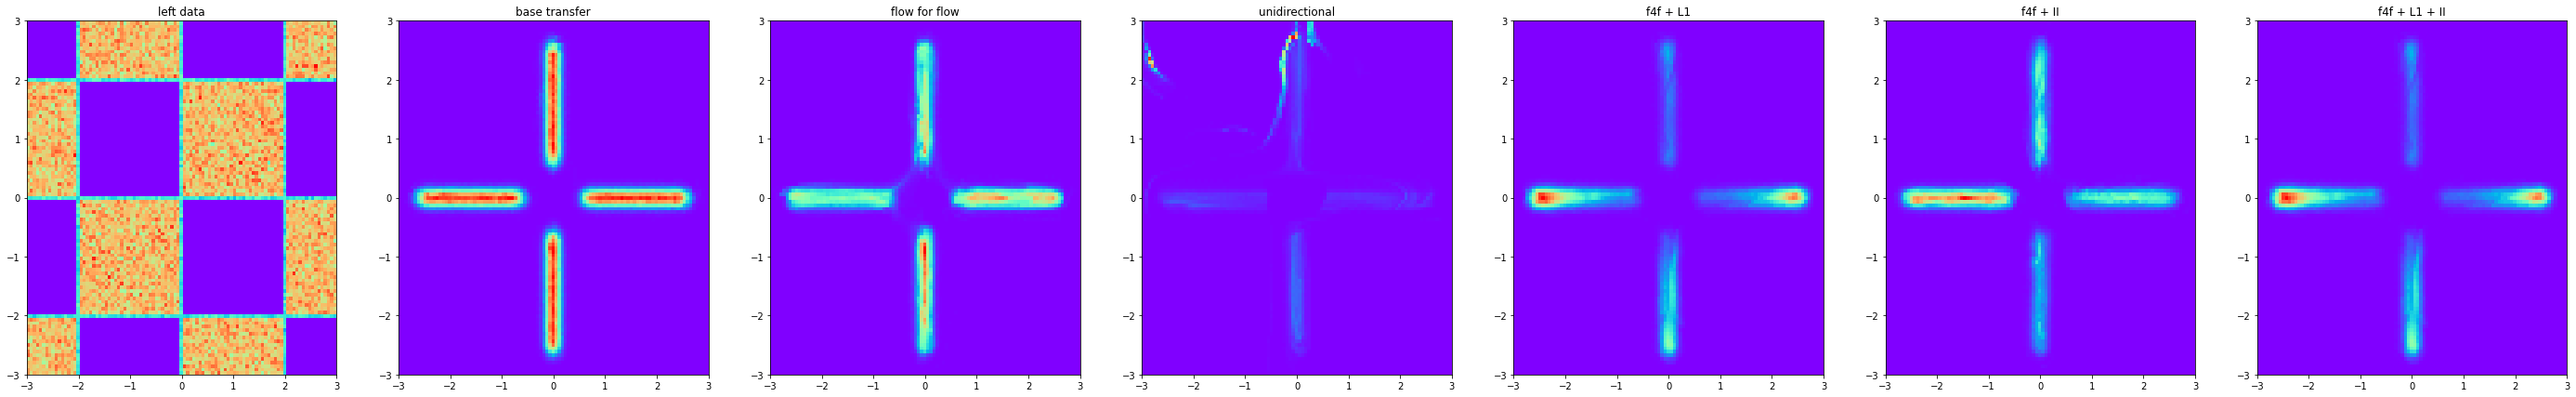

In [3]:

# get the data
ring_dir = collect_all_data_nocond("checkerboard_star_nocond")
#ring_dir = collect_all_data_nocond("fourcircles_fourcircles_nocond")

# plot
plot_data_nocond(ring_dir, size = 7)

Method baseline : 3.38012 +/- 1.4723
Method base_transfer : 1.9624 +/- 0.8242
Method f4f : 3.70209 +/- 1.51777
Method unidir : 3.21602 +/- 1.5276
Method L1 : 1.78345 +/- 1.10254
Method II : 3.38724 +/- 1.32776
Method L1_II : 1.78345 +/- 1.10254


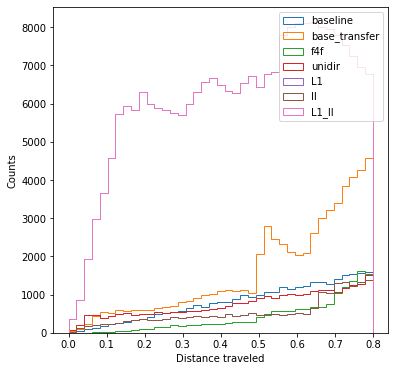

In [4]:
# calculate distances
    
calculate_distance_and_plot(ring_dir, bins = np.linspace(0, .8, 40))

# ncond = 1

In [2]:
eval_results_dir = "~/flows4flows/writeup2/"


def collect_all_data_yescond(key, code):
    
    transported_results = {"left":[0,0], # x, y
                           "base_transfer":[0,0],
                           "f4f":[0,0],
                           "unidir_start":[0,0],
                           "unidir_end":[0,0],
                           "L1_start":[0,0],
                           "L1_end":[0,0],
                                }
    
    eval_dict_root = f"{eval_results_dir}/{key}_f4f/"
    results_root = pd.read_hdf(f"{eval_dict_root}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{code}")
    
    transported_results["left"] = [results_root["input_x"], results_root["input_y"]]

    transported_results["base_transfer"] = [results_root["base_transfer_x"], results_root["base_transfer_y"]]
    transported_results["f4f"] = [results_root["transformed_x"], results_root["transformed_y"]]
    
    # unidir
    eval_dict_unidir = f"{eval_results_dir}/{key}_inv/"
    results_unidir = pd.read_hdf(f"{eval_dict_unidir}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{code}")
    transported_results["unidir_start"] = [results_unidir["input_x"], results_unidir["input_y"]]
    transported_results["unidir_end"] = [results_unidir["transformed_x"], results_unidir["transformed_y"]]


    # L1
    eval_dict_l1 = f"{eval_results_dir}/{key}_L1/"
    results_l1 = pd.read_hdf(f"{eval_dict_l1}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{code}")
    transported_results["L1_start"] = [results_l1["input_x"], results_l1["input_y"]]
    transported_results["L1_end"] = [results_l1["transformed_x"], results_l1["transformed_y"]]

    
    # II
    eval_dict_identinit = f"{eval_results_dir}/{key}_identinit/"
    results_identinit = pd.read_hdf(f"{eval_dict_identinit}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{code}")
    transported_results["II_start"] = [results_identinit["input_x"], results_identinit["input_y"]]
    transported_results["II_end"] = [results_identinit["transformed_x"], results_identinit["transformed_y"]]
    
    # L1 + II
    eval_dict_identinit = f"{eval_results_dir}/{key}_L1_identinit/"
    results_identinit = pd.read_hdf(f"{eval_dict_identinit}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{code}")
    transported_results["L1_II_start"] = [results_identinit["input_x"], results_identinit["input_y"]]
    transported_results["L1_II_end"] = [results_identinit["transformed_x"], results_identinit["transformed_y"]]
    
    
    
    return transported_results


def plot_data_yescond(results_dir, size = 4):
    
    cmap = "rainbow"
    b = np.linspace(-3, 3, 100)
    

    fig, ax = plt.subplots(1, 7, figsize = (7*size, size))

    ax[0].hist2d(results_dir["left"][0], results_dir["left"][1], bins = b, cmap = cmap)
    ax[0].set_title("left data")
    
    ax[1].hist2d(results_dir["base_transfer"][0], results_dir["base_transfer"][1], bins = b, cmap = cmap)
    ax[1].set_title("base transfer")
    
    ax[2].hist2d(results_dir["f4f"][0], results_dir["f4f"][1], bins = b, cmap = cmap)
    ax[2].set_title("flow for flow")
    
    ax[3].hist2d(results_dir["unidir_end"][0], results_dir["unidir_end"][1], bins = b, cmap = cmap)
    ax[3].set_title("unidirectional") 

    ax[4].hist2d(results_dir["L1_end"][0], results_dir["L1_end"][1], bins = b, cmap = cmap)
    ax[4].set_title("f4f + L1")
    
    ax[5].hist2d(results_dir["II_end"][0], results_dir["II_end"][1], bins = b, cmap = cmap)
    ax[5].set_title("f4f + ident init")
    
    ax[6].hist2d(results_dir["L1_II_start"][0], results_dir["L1_II_end"][1], bins = b, cmap = cmap)
    ax[6].set_title("f4f + L1 + ident init")
    
        
     
    fig.show()
    

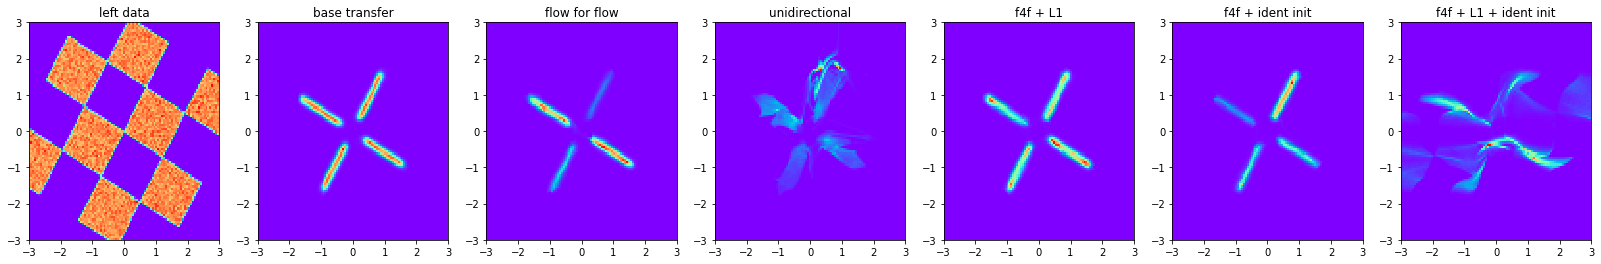

In [3]:

# get the data
#spirals_dir = collect_all_data_yescond("checkerboard_checkerboard_rotation", "30_00")
spirals_dir = collect_all_data_yescond("checkerboard_star_rotation", "30_00")
#spirals_dir = collect_all_data_yescond("checkerboard_fourcircles_rotation", "30_00")

# plot
plot_data_yescond(spirals_dir)

In [ ]:
calculate_distance_and_plot(spirals_dir, bins = np.linspace(0, 4, 40), baseline = False)

# Science

In [13]:
# Get training data

train_sim_data = torch.from_numpy(np.load("LHCO_data/train_sim_data.npy")).to(torch.float32)
val_sim_data = torch.from_numpy(np.load("LHCO_data/val_sim_data.npy")).to(torch.float32)
train_dat_data = torch.from_numpy(np.load("LHCO_data/train_dat_data.npy")).to(torch.float32)
val_dat_data = torch.from_numpy(np.load("LHCO_data/val_dat_data.npy")).to(torch.float32)

train_sim_cont = torch.from_numpy(np.load("LHCO_data/train_sim_cont.npy").reshape(-1, 1)).to(torch.float32)
val_sim_cont = torch.from_numpy(np.load("LHCO_data/val_sim_cont.npy").reshape(-1, 1)).to(torch.float32)
train_dat_cont = torch.from_numpy(np.load("LHCO_data/train_dat_cont.npy").reshape(-1, 1)).to(torch.float32)
val_dat_cont = torch.from_numpy(np.load("LHCO_data/val_dat_cont.npy").reshape(-1, 1)).to(torch.float32)

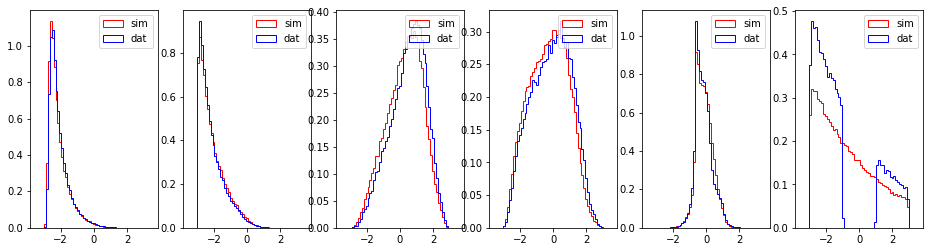

In [14]:
# Plot training data

bins = np.linspace(-3.5, 3.5, 60)

fig, ax = plt.subplots(1, 6, figsize = (16, 4))

for i in range(5):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
    ax[i].legend()
    
# context
ax[5].hist(val_sim_cont.numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
ax[5].hist(val_dat_cont.numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
ax[5].legend()
    
plt.show()

In [20]:
# load in the flow



baseflow_dir = "/global/home/users/rrmastandrea/flows4flows/writeup2/science/"

with open(f"{baseflow_dir}/cond_transfer.yaml") as f:
    defaults = yaml.safe_load(f)
    
base_flow_left_path = f"{baseflow_dir}/base_left/epoch_49_valloss_4.864.pt"
base_flow_right_path = f"{baseflow_dir}/base_right/epoch_49_valloss_4.770.pt"


flow_paths = {"f4f_fwd":"/global/home/users/rrmastandrea/flows4flows/writeup/science/f4f_fwd/epoch_49_valloss_4.805.pt",
              "f4f_inv":"/global/home/users/rrmastandrea/flows4flows/writeup/science/f4f_inv/epoch_49_valloss_4.904.pt",
             }
              
    
    

FileNotFoundError: [Errno 2] No such file or directory: '/global/home/users/rrmastandrea/flows4flows/writeup2/science//cond_transfer.yaml'

In [19]:
# load in the flow

base_flow_left = BaseFlow(spline_inn(defaults["general"]["data_dim"],
                                    nodes = defaults["base_dist"]["left"]["nnodes"],
                                 num_blocks =   defaults["base_dist"]["left"]["nblocks"],
                                    num_stack = defaults["base_dist"]["left"]["nstack"],
                                    tail_bound=4.0,
                                    num_bins=defaults["base_dist"]["left"]["nbins"],
                                    context_features=defaults["general"]["ncond"]
                                    ),
                         StandardNormal([defaults["general"]["data_dim"]])
                         )
base_flow_left.load_state_dict(torch.load(base_flow_left_path, map_location=device))
set_trainable(base_flow_left, False)

base_flow_right = BaseFlow(spline_inn(defaults["general"]["data_dim"],
                                    nodes = defaults["base_dist"]["right"]["nnodes"],
                                 num_blocks =   defaults["base_dist"]["right"]["nblocks"],
                                    num_stack = defaults["base_dist"]["right"]["nstack"],
                                    tail_bound=4.0,
                                    num_bins=defaults["base_dist"]["right"]["nbins"],
                                    context_features=defaults["general"]["ncond"]
                                    ),
                         StandardNormal([defaults["general"]["data_dim"]])
                         )
base_flow_right.load_state_dict(torch.load(base_flow_right_path, map_location=device)) 
set_trainable(base_flow_right, False)


transfer_flows = {}

for iid in flow_paths.keys():
    
    if iid == "identinit":
        identity_init = 1
    else:
        identity_init = 0
        
    print(iid, identity_init)
        
    
    transfer_flows[iid] = get_flow4flow('discretebasecondition',
                               spline_inn(defaults["general"]["data_dim"],
                                          nodes=defaults["top_transformer"]["nnodes"],
                                          num_blocks=defaults["top_transformer"]["nblocks"],
                                          num_stack=defaults["top_transformer"]["nstack"],
                                          tail_bound=4.0,
                                          activation=get_activation(defaults["top_transformer"]["activation"]),
                                          num_bins=defaults["top_transformer"]["nbins"],
                                          context_features=defaults["general"]["ncond"],
                                          flow_for_flow=True,
                                          identity_init = identity_init
                                          ),
                               distribution_right=base_flow_right,
                               distribution_left=base_flow_left)
    
    transfer_flows[iid].load_state_dict(torch.load(flow_paths[iid], map_location=device)) 
    set_trainable(transfer_flows[iid], False)   



f4f_fwd 0


FileNotFoundError: [Errno 2] No such file or directory: '/global/home/users/rrmastandrea/flows4flows/writeup/science_f4f/f4f_fwd/epoch_49_valloss_4.805.pt'

In [ ]:
# check base densities

n_transform = 55753 # size of dat (smaller) dataset

noise = torch.normal(0, 1, size=(n_transform, 5))
bd_samples_sim, _ = base_flow_left._transform.inverse(noise, val_sim_cont[:n_transform])
bd_samples_dat, _ = base_flow_right._transform.inverse(noise, val_dat_cont[:n_transform])


bins = np.linspace(-3.5, 3.5, 60)

fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(bd_samples_sim[:,i].numpy(), bins = bins, label = "bd", histtype = "bar", density = True, color = "red", alpha = 0.5)

    ax[i].legend(loc = "lower right")
    
plt.show()


fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "blue")
    ax[i].hist(bd_samples_dat[:,i].numpy(), bins = bins, label = "bd", histtype = "bar", density = True, color = "blue", alpha = 0.5)

    ax[i].legend(loc = "lower right")
    
plt.show()




In [ ]:
ndat = 55753

flow_transforms = {}


for iid in flow_paths.keys():
    
    # Transform the data
    transformed_data, _ = transfer_flows[iid].batch_transform(val_sim_data[:ndat], val_sim_cont[:ndat], val_sim_cont[:ndat], batch_size=1000)
    flow_transforms[iid] = transformed_data.numpy()
    
# Get the transformation that results from going via the base distributions
left_bd_enc = base_flow_left.transform_to_noise(val_sim_data[:ndat], val_sim_cont[:ndat])
right_bd_dec, _ = base_flow_right._transform.inverse(left_bd_enc, val_sim_cont[:ndat].view(-1, 1))

flow_transforms["base_transform"] = right_bd_dec.numpy()

flow_transforms["input"] = val_sim_data[:ndat].numpy()
flow_transforms["target"] = val_dat_data[:ndat].numpy()



In [ ]:
keys_to_plot = ["input", "target", "l1", "identinit"]

bins = np.linspace(-3.5, 3.5, 40)

fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    
    for iid in keys_to_plot:
        
        ax[i].hist(flow_transforms[iid][:,i], bins = bins, label = iid, histtype = "step", density = True)

    ax[i].legend(loc = "lower right")
    
plt.show()



In [ ]:
def calculate_distance_lhco(results_dir, key_1, key_2, index = None):
    
    if index is not None:
        dists = np.linalg.norm(results_dir[key_1][:,index].reshape(-1, 1) - results_dir[key_2][:,index].reshape(-1, 1), axis = 1)
        
    else:
        dists = np.linalg.norm(results_dir[key_1] - results_dir[key_2], axis = 1)
    return dists

In [ ]:
# total distance


keys_to_plot =  ["input", "target", "l1", "identinit"]

bins = np.linspace(0, 1, 80)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
for i, k in enumerate(keys_to_plot):
    # calculate distance traveled with respect to input
    loc_distances = calculate_distance_lhco(flow_transforms, "input", k)
    if k != "input":
        ax.hist(loc_distances, bins = bins, histtype = "step", label = k)

fig.legend()

ax.set_xlabel("Distance traveled")
ax.set_ylabel("Counts")

fig.show()




# feature distances


fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for j in range(5):

    for i, k in enumerate(keys_to_plot):
        # calculate distance traveled with respect to input
        loc_distances = calculate_distance_lhco(flow_transforms, "input", k, j)
        if k != "input":
            ax[j].hist(loc_distances, bins = bins, histtype = "step", label = k)
            ax[j].set_xlabel(f"Feature {j}")

ax[0].legend()


ax[0].set_ylabel("Counts")

fig.show()